In [2]:
import xarray as xr
import numpy as np
import os
from itertools import chain
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import pandas as pd
from scipy.stats import bootstrap
from scipy.optimize import curve_fit
plt.rcParams.update({'font.size': 14})

In [3]:
TROPOPAUSE_LIST = np.array([16.796782, 16.758917, 16.754074, 16.778471, 16.754147, 16.486168,
                            16.137138, 16.012793, 16.074669, 16.277315, 16.501312, 16.692408])

LABELS = {"z_bases": "Base altitude (km)",
          "z_tops": "Top altitude (km)",
          "z_max_capas": "Max. backscatter altitude (km)",
          "thickness": "Thickness (km)",
          "lidar_ratio": "Lidar ratio (sr)",
          "cod": "Cloud optical depth",
          "month": "Month",
          "hour": "Local time (h)",
          "year": "Year",
          "percentil_25": r"$25^{th}$ percentile",
          "percentil_75": r"$75^{th}$ percentile",
          "tropopause_base": "Distance from tropopause to base (km)",
          "tropopause_top": "Distance from tropopause to top (km)",
          "temperature_base": "Base temperature (°C)"}

DIR_SAVE = "figs_en"

LABELS_PERIOD = ['Annual', 'Wet season', 'Trans', 'Dry season']

LABELS_CAT = ['Opaque', 'Thin', 'SVC']

LABELS_PERIOD_2 = ['Wet season', 'Dry season']

MONTHS = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sept', 'Oct', 'Nov', 'Dec']

PERIOD_DIC = {'Wet': 'Wet season', 'Dry': 'Dry season'}

def create_latex_table_first(total, wet, trans, dry):
    print("\\hline")
    print(" & Total & Wet & Transition & Dry \\\\")
    print("\\hline")

    rows = [
        "No. of measured profiles",
        "No. of profiles used in the analysis",
        "No. of profiles discarded due to signal-to-noise ratio",
        "No. of profiles discarded due to apparent top",
        "No. of profiles with cirrus",
        "Occurrence frequency (%)",
        "Occurrence frequency of opaque cirrus (%)",
        "Occurrence frequency of thin cirrus (%)",
        "Occurrence frequency of subvisual cirrus (%)",
        "No. of cirrus layers per profile with cirrus"
    ]

    for i in range(len(rows)):
        print(f"{rows[i]} & {total[i]} & {wet[i]} & {trans[i]} & {dry[i]} \\\\")
    print("\\hline")

In [4]:
def data_year(ax_, order):
    df1 = (
        df
        .drop_duplicates('time')
        .groupby(['year', 'month'])['time']
        .count()
        .reset_index()
        .assign(year_month=lambda x: x.year + (x.month - 1) / 12)
    )

    df2 = (
        df
        [df.cond_s_bg]
        .drop_duplicates('time')
        .groupby(['year', 'month'])['time']
        .count()
        .reset_index()
        .assign(year_month=lambda x: x.year + (x.month - 1) / 12)
    )

    ax_.grid()
    for side in ['right', 'top', 'bottom', 'left']:
        ax_.spines[side].set_alpha(0.4)

    ax_.bar(df1['year_month'], df1['time'], width=1/20, color="#d62728", alpha=0.7,
            label='Total')
    ax_.bar(df2['year_month'], df2['time'], width=1/20, color="#1f77b4", alpha=0.7,
            label='Good SNR')
    ax_.legend()

    ax_.set_title('Time series')

    if order is not None:
        ax_.text(.5, 0.92, order, transform=ax_.transAxes, verticalalignment='center',
                 horizontalalignment='center', weight='bold')

def data_month(ax_, order):
    df1 = (
        df
        .drop_duplicates('time')
        .groupby(['month'])['time']
        .count()
        .reset_index()
    )

    df2 = (
        df
        [df.cond_s_bg]
        .drop_duplicates('time')
        .groupby(['month'])['time']
        .count()
        .reset_index()
    )

    ax_.grid()
    for side in ['right', 'top', 'bottom', 'left']:
        ax_.spines[side].set_alpha(0.4)

    ax_.bar(MONTHS, df1['time'], width=1/1.5, color="#d62728", alpha=0.7)
    ax_.bar(MONTHS, df2['time'], width=1/1.5, color="#1f77b4", alpha=0.7)

    ax_.set_ylabel('Number of 5-min profiles')

    ax_.set_title('Climatology')

    if order is not None:
        ax_.text(.5, 0.92, order, transform=ax_.transAxes, verticalalignment='center',
                 horizontalalignment='center', weight='bold')

def data_hour(ax_, order):
    df1 = (
        df
        .drop_duplicates('time')
        .groupby(['hour'])['time']
        .count()
        .reset_index()
    )

    df2 = (
        df
        [df.cond_s_bg]
        .drop_duplicates('time')
        .groupby(['hour'])['time']
        .count()
        .reset_index()
    )

    ax_.grid()
    ax_.set_xlabel('Local time (h)')
    for side in ['right', 'top', 'bottom', 'left']:
        ax_.spines[side].set_alpha(0.4)

    ax_.bar(df1['hour'], df1['time'], width=1/2, color="#d62728", alpha=0.7)
    ax_.bar(df2['hour'], df2['time'], width=1/2, color="#1f77b4", alpha=0.7)

    ax_.set_title('Diurnal cycle')

    if order is not None:
        ax_.text(.5, 0.92, order, transform=ax_.transAxes, verticalalignment='center',
                 horizontalalignment='center', weight='bold')

cod<0.005: 7.8 %



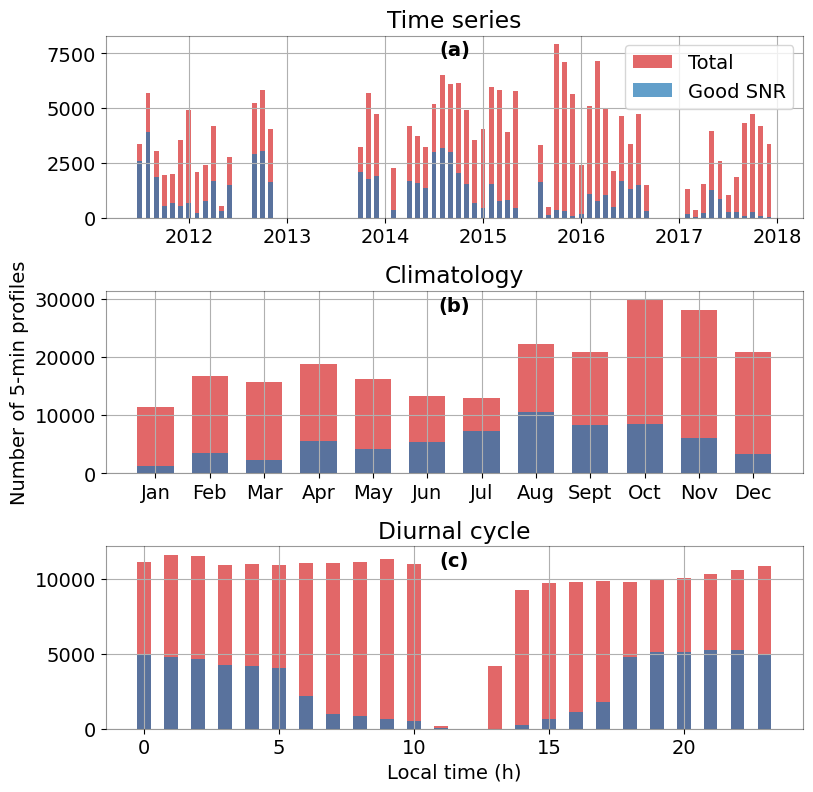

\hline
 & Total & Wet & Transition & Dry \\
\hline
No. of measured profiles & 226985 & 62833 & 94927 & 69225 \\
No. of profiles used in the analysis & 65537 & 12463 & 21678 & 31396 \\
No. of profiles discarded due to signal-to-noise ratio & 160952 & 50225 & 72984 & 37743 \\
No. of profiles discarded due to apparent top & 496 & 145 & 265 & 86 \\
No. of profiles with cirrus & 46977 & 10565 & 18427 & 17985 \\
Occurrence frequency (%) & 73.2 & 82.8 & 82.5 & 54.5 \\
Occurrence frequency of opaque cirrus (%) & 15.9 & 18.4 & 17.9 & 11.5 \\
Occurrence frequency of thin cirrus (%) & 33.0 & 37.0 & 39.1 & 22.8 \\
Occurrence frequency of subvisual cirrus (%) & 20.5 & 22.8 & 20.0 & 18.8 \\
No. of cirrus layers per profile with cirrus & 1.41 (0.61) & 1.51 (0.68) & 1.47 (0.63) & 1.28 (0.51) \\
\hline


In [5]:
df = pd.read_csv('df_cirrus_master.csv')

dummy = df[df.cirrus & (~df.fake_top1) & (df.cond_s_bg) & (~df.cod.isna())]

print('cod<0.005:', np.round((len(dummy[dummy.cod <= 0.005]) / len(dummy) * 100), 1), '%')
print()

df = df[(df.cod >= 0.005) | np.isnan(df.cod)]

total = []
wet = []
trans = []
dry = []

fig, ax = plt.subplots(nrows = 3, figsize=(9,9))
fig.subplots_adjust(hspace=0.4)
data_year(ax[0], '(a)')
data_month(ax[1], '(b)')
data_hour(ax[2],  '(c)')
plt.savefig(f"{DIR_SAVE}/data", dpi=300)
plt.show()

total.append(len(df.drop_duplicates('time')))
wet.append(len(df[df.period == "Wet"].drop_duplicates('time')))
trans.append(len(df[df.period == "Trans"].drop_duplicates('time')))
dry.append(len(df[df.period == "Dry"].drop_duplicates('time')))

snr_total = len(df[~df.cond_s_bg].drop_duplicates('time'))
snr_wet = len(df[(df.period == "Wet") & (~df.cond_s_bg)].drop_duplicates('time'))
snr_trans = len(df[(df.period == "Trans") & (~df.cond_s_bg)].drop_duplicates('time'))
snr_dry = len(df[(df.period == "Dry") & (~df.cond_s_bg)].drop_duplicates('time'))

df = df[df.cond_s_bg]

total.append(len(df[~df.fake_top1].drop_duplicates('time')))
wet.append(len(df[(df.period == "Wet") & (~df.fake_top1)].drop_duplicates('time')))
trans.append(len(df[(df.period == "Trans") & (~df.fake_top1)].drop_duplicates('time')))
dry.append(len(df[(df.period == "Dry") & (~df.fake_top1)].drop_duplicates('time')))

total.append(snr_total)
wet.append(snr_wet)
trans.append(snr_trans)
dry.append(snr_dry)

total.append(total[0] - total[1] - total[2])
wet.append(wet[0] - wet[1] - wet[2])
trans.append(trans[0] - trans[1] - trans[2])
dry.append(dry[0] - dry[1] - dry[2])

total.append(len(df[(~df.fake_top1) & df.cirrus].drop_duplicates('time')))
wet.append(len(df[(~df.fake_top1) & df.cirrus & (df.period == "Wet")].drop_duplicates('time')))
trans.append(len(df[(~df.fake_top1) & df.cirrus & (df.period == "Trans")].drop_duplicates('time')))
dry.append(len(df[(~df.fake_top1) & df.cirrus & (df.period == "Dry")].drop_duplicates('time')))

freq = (df
        [(~df.hour.isin([11, 12, 13, 14]))]
        .sort_values("z_tops").drop_duplicates("time", keep="last")
        .groupby(["period", "month", "hour"])["cirrus"].mean().reset_index()
        .groupby(["period", "month"])["cirrus"].mean().reset_index()
        .groupby(["period"])["cirrus"].mean()
        * 100)

total.append(f"{freq.mean().round(1)}")
wet.append(f"{freq.loc['Wet'].round(1)}")
trans.append(f"{freq.loc['Trans'].round(1)}")
dry.append(f"{freq.loc['Dry'].round(1)}")

dic_1 = {"opaque": 1, "thin": 2, "subvisual": 3}
dic_2 = {"opaque": 3, "thin": 1, "subvisual": 2}
dic_3 = {"opaque": 2, "thin": 3, "subvisual": 1}

for class_, dic in zip(["opaque", "thin", "subvisual"],
                         [dic_1, dic_2, dic_3]):
    freq = (df
            [(~df.hour.isin([11, 12, 13, 14]))]
            .assign(cat=lambda x: x.class_ == class_)
            .assign(num_type=lambda x: x.cat.map(dic))
            .sort_values(["time", "num_type", "z_tops"])
            .drop_duplicates("time", keep="first")
            .groupby(["period", "month","hour"])["cat"].mean().reset_index()
            .groupby(["period", "month"])["cat"].mean().reset_index()
            .groupby(["period"])["cat"].mean()
            * 100)

    total.append(f"{freq.mean().round(1)}")
    wet.append(f"{freq.loc['Wet'].round(1)}")
    trans.append(f"{freq.loc['Trans'].round(1)}")
    dry.append(f"{freq.loc['Dry'].round(1)}")

# 1) Filtro único
mask_valid = (~df.fake_top1) & df.cirrus & (df.cod >= 0.005)
valid = df.loc[mask_valid]

layers_per_time = valid.groupby('time').size()

mean_all, std_all = layers_per_time.agg(['mean', 'std']).round(2)
total.append(f"{mean_all} ({std_all})")

base = (
    valid
    .assign(layers=valid.groupby('time')['time'].transform('size'))
    .drop_duplicates('time')
)

layers_stats = (
    base
    .groupby('period')['layers']
    .agg(['mean', 'std'])
    .round(2)
)

for periodo, destino in [('Wet', wet),
                         ('Trans', trans),
                         ('Dry', dry)]:
    media, desvio = layers_stats.loc[periodo]
    destino.append(f"{media} ({desvio})")


create_latex_table_first(total, wet, trans, dry)

df =df[~df.fake_top1]

# Frequency of occurence

## Diurnal cycle

In [6]:
def ciclo_diurno_freq(ax_, order=None):
    dfs =[pd.read_csv(file, sep=";") for file in ["prec_dry.csv", "prec_trans.csv", "prec_dry.csv", "prec_total.csv"]]

    df_freq = df[(~df.hour.isin([11, 12, 13]))].sort_values("z_tops").drop_duplicates("time", keep="last")

    df_freq = (df_freq
               .assign(time=lambda x: pd.to_datetime(x.time))
               .assign(hour=lambda x: np.round(x.time.dt.hour + x.time.dt.minute / 60)))

    df_freq.loc[df_freq.hour == 24, "hour"] = 0

    width = 1/3

    mensal_period = df_freq.groupby(["period", "hour"])["cirrus"].mean()
    count_period = (df_freq.groupby(["period", "hour"])["cirrus"].count())
    error_period = np.sqrt(mensal_period * (1 - mensal_period) / count_period)

    mensal_total = df_freq.groupby(["hour"])["cirrus"].mean()
    count_total = df_freq.groupby("hour")["cirrus"].count()
    error_total = np.sqrt(mensal_total * (1 - mensal_total) / count_total)

    periods = []
    hours = []
    cirrus = []
    for hour in [12, 13]:
        for period in mensal_period.reset_index().period.unique():
            periods.append(period)
            hours.append(hour)
            cirrus.append(np.nan)

    dict_ = {'period': periods,
             'hour': hours,
             'cirrus': cirrus}

    count_period = count_period.reset_index()
    mensal_period = mensal_period.reset_index()
    error_period = error_period.reset_index()

    mensal_total = pd.concat([mensal_total, pd.Series([np.nan] * 2, index=[12, 13])]).sort_index()

    mensal_period = pd.concat([mensal_period, pd.DataFrame(dict_)]).sort_values(by=["period", "hour"]).reset_index(drop=True)
    error_period = pd.concat([error_period, pd.DataFrame(dict_)]).sort_values(by=["period", "hour"]).reset_index(drop=True)


    for i, (df_, c) in enumerate(zip(dfs, ["#1f77b4", "g", "#d62728", "k"])):
        if i == 1:
            continue
        ax_.plot(df_["hour"], df_[" freq"], "--", color=c, alpha=0.7)

    barras = []
    for period, c in zip(["Wet", "Dry"], ["#1f77b4", "#d62728"]):
        count_temp = count_period[count_period.period == period]
        mensal_temp = mensal_period[mensal_period.period == period]
        error_temp = error_period[error_period.period == period]


        ax_.plot(mensal_temp.hour, mensal_temp.cirrus, color=c, linewidth=2.5, alpha=0.7, label=PERIOD_DIC[period])
        ax_.fill_between(mensal_temp.hour, mensal_temp.cirrus - error_temp.cirrus, mensal_temp.cirrus + error_temp.cirrus, color=c, alpha=0.2)

    ax_.plot(mensal_total.index, mensal_total, color="k", linewidth=2.5, alpha=0.7, label="Anual")
    ax_.fill_between(mensal_total.index, mensal_total - error_total, mensal_total + error_total, color="k", alpha=0.3)

    df_freq = df[~df.hour.isin([11, 12, 13])].sort_values("z_tops").drop_duplicates("time", keep="last")

    df_freq = (df_freq
               .assign(time=lambda x: pd.to_datetime(x.time))
               .assign(hour=lambda x: np.round(x.time.dt.hour + x.time.dt.minute / 60)))

    df_freq.loc[df_freq.hour == 24, "hour"] = 0

    width = 1/3

    mensal_period = df_freq.groupby(["period", "hour"])["cirrus"].mean()
    count_period = (df_freq.groupby(["period", "hour"])["cirrus"].count())
    error_period = np.sqrt(mensal_period * (1 - mensal_period) / count_period)

    mensal_total = df_freq.groupby(["hour"])["cirrus"].mean()
    count_total = df_freq.groupby("hour")["cirrus"].count()
    error_total = np.sqrt(mensal_total * (1 - mensal_total) / count_total)


    periods = []
    hours = []
    cirrus = []
    for hour in [12, 13]:
        for period in mensal_period.reset_index().period.unique():
            periods.append(period)
            hours.append(hour)
            cirrus.append(np.nan)

    dict_ = {'period': periods,
             'hour': hours,
             'cirrus': cirrus}

    count_period = count_period.reset_index()
    mensal_period = mensal_period.reset_index()
    error_period = error_period.reset_index()

    mensal_total1 = pd.concat([mensal_total, pd.Series([np.nan] * 2, index=[12, 13])]).sort_index()
    error_total1 = error_total
    mensal_period1 = pd.concat([mensal_period, pd.DataFrame(dict_)]).sort_values(by=["period", "hour"]).reset_index(drop=True)
    error_period1 = pd.concat([error_period, pd.DataFrame(dict_)]).sort_values(by=["period", "hour"]).reset_index(drop=True)

    ax_.grid()

    line1, = ax_.plot([], [], color='k', linestyle='--', label='Gouveia et al. (2017)')
    line3, = ax_.plot([], [],  color='k', linestyle='-', label='This work')

    legend1 = ax_.legend(handles=[line1, line3], loc='lower right', title='Line', fontsize=12)
    ax_.add_artist(legend1)

    import matplotlib.patches as mpatches

# Criar os patches
    patch1 = mpatches.Patch(color="#1f77b4", alpha=0.7, label='Wet season')
    patch2 = mpatches.Patch(color="k", alpha=0.7, label='Annual')
    patch3 = mpatches.Patch(color="#d62728", alpha=0.7, label='Dry season')

    # Adicionar os patches à legenda
    legend2 = ax_.legend(handles=[patch1, patch2, patch3], loc='lower left', title='Colour', fontsize=12)

    ax_.add_artist(legend2)

    ax_.set_ylabel("Frequency of occurrence", fontsize=17)

    ax_.set_ylim([0, 1])
    for side in ['right', 'top', 'bottom', 'left']:
        ax_.spines[side].set_alpha(0.4)

    if order is not None:
        ax_.text(.5, 1.05, order, transform=ax_.transAxes, verticalalignment='center',
                 horizontalalignment='center', weight='bold')



def ciclo_diurno_freq_cat(ax_, period=None, order=None):
    df_ = (df
           .assign(subvisual=lambda x: x.class_ == "subvisual")
           .assign(thin=lambda x: x.class_ == "thin")
           .assign(opaque=lambda x: x.class_ == "opaque"))

    if period is not None:
        df_ = df_[df_.period == period]

    data_svc = df_.groupby('hour')['subvisual'].mean()
    data_thin = df_.groupby('hour')['thin'].mean()
    data_opaque = df_.groupby('hour')['opaque'].mean()

    data_svc_std = np.sqrt(data_svc * (1 - data_svc) / df_.groupby('hour')['subvisual'].count())
    data_thin_std = np.sqrt(data_thin * (1 - data_thin) / df_.groupby('hour')['thin'].count())
    data_opaque_std = np.sqrt(data_opaque * (1 - data_opaque) / df_.groupby('hour')['opaque'].count())

    for data in [data_svc, data_thin, data_opaque]:
        data.loc[11:13] = np.nan
        data = pd.concat([data, pd.Series([np.nan, np.nan, np.nan], index=[11, 12, 13])]).sort_index()

    colors = ['#800080', '#FFA500', '#00FFFF']

    for i, (data, data_std) in enumerate(zip([data_opaque, data_thin, data_svc],
                                             [data_opaque_std, data_thin_std, data_svc_std])):
        ax_.plot(data.index, data.sort_index(), linewidth=2.5, alpha=0.6, color=colors[i], label=LABELS_CAT[i])
        ax_.fill_between(data.index, data - data_std, data + data_std, color=colors[i], alpha=0.2)

    ax_.set_ylabel("Frequency of occurrence", fontsize=17)
    ax_.grid()
    ax_.legend()
    ax_.set_ylim([0, 0.55])
    for side in ['right', 'top', 'bottom', 'left']:
        ax_.spines[side].set_alpha(0.4)

    if order is not None:
        ax_.text(.5, 1.05, order, transform=ax_.transAxes, verticalalignment='center',
                 horizontalalignment='center', weight='bold')


def precip(ax_, order=None):
    df_precip = pd.read_csv('precip_2011_2017_cmorph.csv')

    wet_mean = df_precip[df_precip.month.isin([1,2,3,4])].groupby('hour')['cmorph_mean'].mean()
    wet_std = (df_precip[df_precip.month.isin([1,2,3,4])]
                   .groupby(['year', 'hour'])['cmorph_mean'].mean().reset_index()
                   .groupby(['hour'])['cmorph_mean'].std(ddof=1))

    dry_mean = df_precip[df_precip.month.isin([6,7,8,9])].groupby('hour')['cmorph_mean'].mean()
    dry_std = (df_precip[df_precip.month.isin([6,7,8,9])]
                .groupby(['year', 'hour'])['cmorph_mean'].mean().reset_index()
                   .groupby(['hour'])['cmorph_mean'].std(ddof=1))

    annual_mean = df_precip.groupby('hour')['cmorph_mean'].mean()
    annal_std = (df_precip
                 .groupby(['year', 'hour'])['cmorph_mean'].mean().reset_index()
                 .groupby(['hour'])['cmorph_mean'].std(ddof=1))

    ax_.plot(wet_mean.index, wet_mean, linewidth=2.5, alpha=.7, color='#1f77b4', label='Wet season')
    ax_.fill_between(wet_mean.index, wet_mean - wet_std, wet_mean + wet_std, color='#1f77b4', alpha=0.2)

    ax_.plot(dry_mean.index, dry_mean, linewidth=2.5, alpha=.7, color='#d62728', label='Dry season')
    ax_.fill_between(dry_mean.index, dry_mean - dry_std, dry_mean + dry_std, color='#d62728', alpha=0.2)

    ax_.set_xlabel('Local time (h)', fontsize=17)
    ax_.set_ylabel('Precipitation rate (mm/h)', fontsize=17)
    ax_.legend()
    ax_.grid()

    for side in ['right', 'top', 'bottom', 'left']:
            ax_.spines[side].set_alpha(0.4)

    if order is not None:
        ax_.text(.5, 1.05, order, transform=ax_.transAxes, verticalalignment='center',
                 horizontalalignment='center', weight='bold')


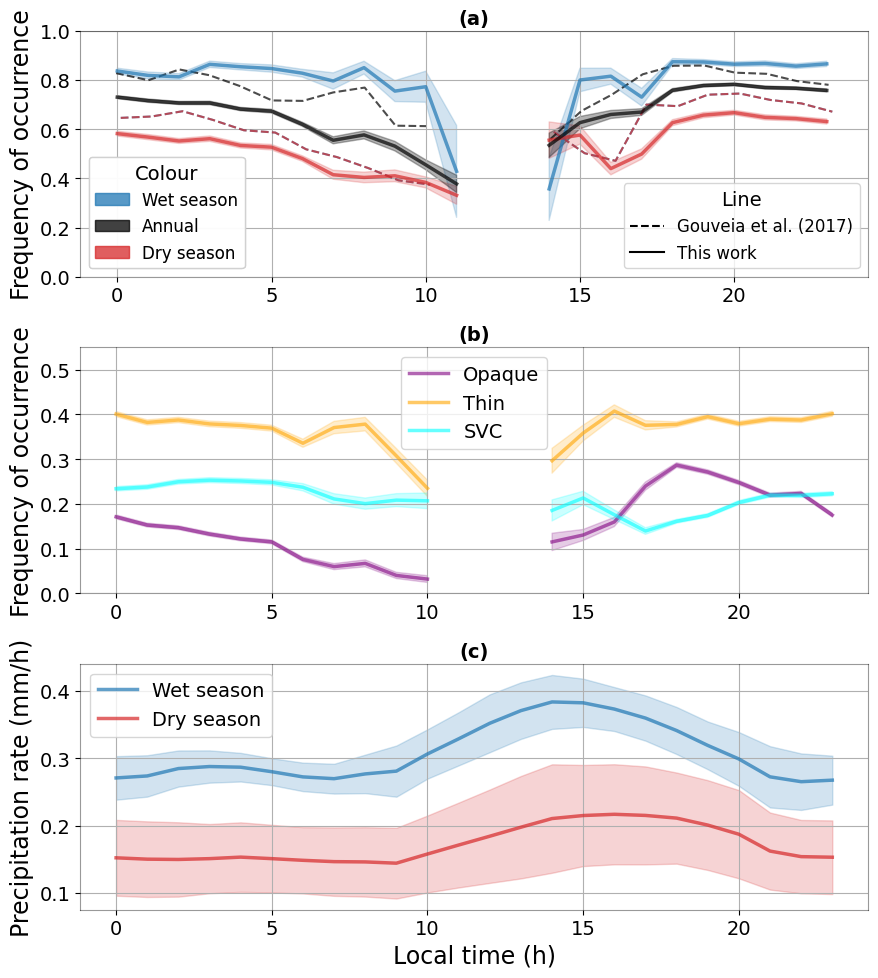

In [7]:
fig, ax = plt.subplots(figsize=(9, 10), nrows=3)

ciclo_diurno_freq(ax[0], '(a)')
ciclo_diurno_freq_cat(ax[1], order='(b)')
precip(ax[2], '(c)')

fig.tight_layout()
plt.savefig(f"{DIR_SAVE}/ciclo_freq_ocorrencia", dpi=300)
plt.show()

## Ciclo Anual

In [8]:
def ciclo_anual(ax_, order=None, cax_=None):
    df_freq = df[(~df.hour.isin([11, 12, 13, 14]))].sort_values("z_tops").drop_duplicates("time", keep="last")

    df_precip_mensal = (pd.read_csv("precipitação-tropopausa/precipitacao.csv")
                        .assign(year=lambda x: pd.to_datetime(x.time).dt.year)
                        .assign(month=lambda x: pd.to_datetime(x.time).dt.month)
                        .groupby(['year', 'month'])['precip'].mean().reset_index()
                        .groupby(['month'])['precip'].agg(['mean', 'std', 'count'])
                        .assign(std_mean=lambda x: x['std'] / np.sqrt(x['count'])))

    df_mensal = df_freq.merge(df_precip_mensal, on='month', how='left')

    contagens = df_freq.groupby("month").count().cirrus

    mensal = (df_freq
     .groupby(["month", "hour"])["cirrus"].mean().reset_index()
     .groupby(["month"]).mean().cirrus)

    error = (df_freq
             .groupby(["year", "month", "hour"])["cirrus"].mean().reset_index()
             .groupby(["year", "month"])["cirrus"].mean().reset_index()
             .groupby(["month"]).std(ddof=1).cirrus)

    ax_.fill_between(MONTHS, 0, 1, where=contagens.index.isin([6,7,8,9]), color='#d62728', alpha=0.1, label=LABELS_PERIOD_2[1])
    ax_.fill_between(MONTHS, 0, 1, where=contagens.index.isin([1,2,3,4]), color='#1f77b4', alpha=0.1, label=LABELS_PERIOD_2[0])
    ax_.plot(MONTHS, mensal, color="#1f77b4", linewidth=2.5, alpha=0.6)
    ax_.fill_between(MONTHS, mensal - error, mensal + error, alpha=0.3)
    ax_.legend()
    ax_.grid(0.5)
    ax_.set_ylim([0, 1])


    ax2 = ax_.twinx()
    ax2.plot(MONTHS, df_precip_mensal["mean"], 'g-', linewidth=1.5, alpha=0.6)
    ax2.fill_between(MONTHS, df_precip_mensal["mean"] - df_precip_mensal["std_mean"],
                     df_precip_mensal["mean"] + df_precip_mensal["std"], color="g", alpha=0.3)
    ax2.set_ylim([2.5, 18])

    ax_.set_ylabel("Frequency of \noccurence", color="#1f77b4")
    ax2.set_ylabel('Precipitation rate (mm/day)', color='g')

    for side in ['right', 'top', 'bottom', 'left']:
        ax_.spines[side].set_alpha(0.4)
        ax2.spines[side].set_alpha(0)

    if order is not None:
        ax_.text(.5, 1.05, order, transform=ax_.transAxes, verticalalignment='center',
                 horizontalalignment='center', weight='bold')

    if cax_ is not None:
        cax_.axis('off')
        divider1 = make_axes_locatable(ax2)
        cax_ = divider1.append_axes("right", size="5%", pad=0.1)
        cax_.axis('off')


def ciclo_anual_cat(ax_, order=None, cax_=None):
    df_ = (df
           [(~df.hour.isin([11, 12, 13, 14]))]
           .assign(subvisual=lambda x: x.class_ == "subvisual")
           .assign(thin=lambda x: x.class_ == "thin")
           .assign(opaque=lambda x: x.class_ == "opaque"))


    data_svc = (df_
                .groupby(['month', 'hour'])['subvisual'])
    data_thin = (df_
                 .groupby(['month', 'hour'])['thin'])
    data_opaque = (df_
                  .groupby(['month', 'hour'])['opaque'])

    for months in [[1,2,3,4], [6,7,8,9]]:
        for data in [data_svc, data_thin, data_opaque]:
            data_temp = data.mean().reset_index()

    data_svc = data_svc.mean().reset_index().groupby(['month']).mean().subvisual
    data_thin = data_thin.mean().reset_index().groupby(['month']).mean().thin
    data_opaque = data_opaque.mean().reset_index().groupby(['month']).mean().opaque

    data_svc_std = (df_
                    .groupby(['year', 'month', 'hour'])['subvisual'].mean().reset_index()
                    .groupby(['year', 'month'])['subvisual'].mean().reset_index()
                    .groupby('month')['subvisual'].std(ddof=1))
    data_thin_std = (df_
                     .groupby(['year', 'month', 'hour'])['thin'].mean().reset_index()
                     .groupby(['year', 'month'])['thin'].mean().reset_index()
                     .groupby('month')['thin'].std(ddof=1))
    data_opaque_std = (df_
                      .groupby(['year', 'month', 'hour'])['opaque'].mean().reset_index()
                      .groupby(['year', 'month'])['opaque'].mean().reset_index()
                      .groupby('month')['opaque'].std(ddof=1))

    colors = ['#800080', '#FFA500', '#00FFFF']

    ax_.fill_between(MONTHS, 0, .65, where=data_opaque.sort_index().index.isin([6,7,8,9]), color='#d62728', alpha=0.1)
    ax_.fill_between(MONTHS, 0, .65, where=data_opaque.sort_index().index.isin([1,2,3,4]), color='#1f77b4', alpha=0.1)
    for i, (data, data_std) in enumerate(zip([data_opaque, data_thin, data_svc],
                                             [data_opaque_std, data_thin_std, data_svc_std])):
        ax_.errorbar(MONTHS, data.sort_index(), linewidth=2.5, alpha=0.6, color=colors[i], label=LABELS_CAT[i])
        ax_.fill_between(MONTHS, (data - data_std).sort_index(), (data + data_std).sort_index(),
                        color=colors[i], alpha=0.2)

    ax_.grid()
    ax_.legend()
    ax_.set_ylabel("Frequency of \noccurence")
    ax_.set_ylim([0, .65])
    for side in ['right', 'top', 'bottom', 'left']:
        ax_.spines[side].set_alpha(0.4)

    if order is not None:
        ax_.text(.5, 1.05, order, transform=ax_.transAxes, verticalalignment='center',
                 horizontalalignment='center', weight='bold')

    if cax_ is not None:
        cax_.axis('off')


def prob(ax_, order=None, cax_=None):
    z = np.arange(6500, 19_000, 200)
    df_freq = df[(~df.hour.isin([11, 12, 13, 14]))].sort_values("z_tops").drop_duplicates("time", keep="last")

    bases = [df_freq[(df_freq.month == month) & df_freq.cirrus].z_bases.to_numpy() for month in np.arange(1, 13)]
    tops = [df_freq[(df_freq.month == month) & df_freq.cirrus].z_tops.to_numpy() for month in np.arange(1, 13)]

    matrix = []
    for month_base, month_top in zip(bases, tops):
        matrix.append(np.array([((z >= base) & (z <= top)) for base, top in zip(month_base, month_top)]).sum(axis=0))

    lengths = [array.sum() for array in matrix]
    matrix = pd.DataFrame(matrix)
    matrix.index = MONTHS
    matrix = matrix.rename(columns={i:val for i, val in enumerate(z)})

    factor = (df[(~df.hour.isin([11, 12, 13, 14]))].sort_values("z_tops").drop_duplicates("time", keep="last")
              .groupby(["month", "hour"])["cirrus"].mean().reset_index()
              .groupby(["month"]).mean().cirrus
              .to_numpy())

    new_matrix = matrix / np.array(lengths).reshape(-1, 1)
    z=new_matrix.T.to_numpy() * factor
    x=new_matrix.T.columns.to_numpy()
    y=new_matrix.T.index.to_numpy()

    cs = ax_.contourf(x, y / 1e3, z, cmap='viridis', levels=15)

    if cax_ is not None:
        cbar = fig.colorbar(cs, cax=cax_)
    else:
        cbar = fig.colorbar(cs)
    cbar.set_label("Frequency of \noccurence")


    ax_.plot(x, TROPOPAUSE_LIST, ':w', alpha=.8, linewidth=3.5)

    ax_.set_ylabel("Altitude (km)")

    if order is not None:
        ax_.text(.5, 1.05, order, transform=ax_.transAxes, verticalalignment='center',
                 horizontalalignment='center', weight='bold')


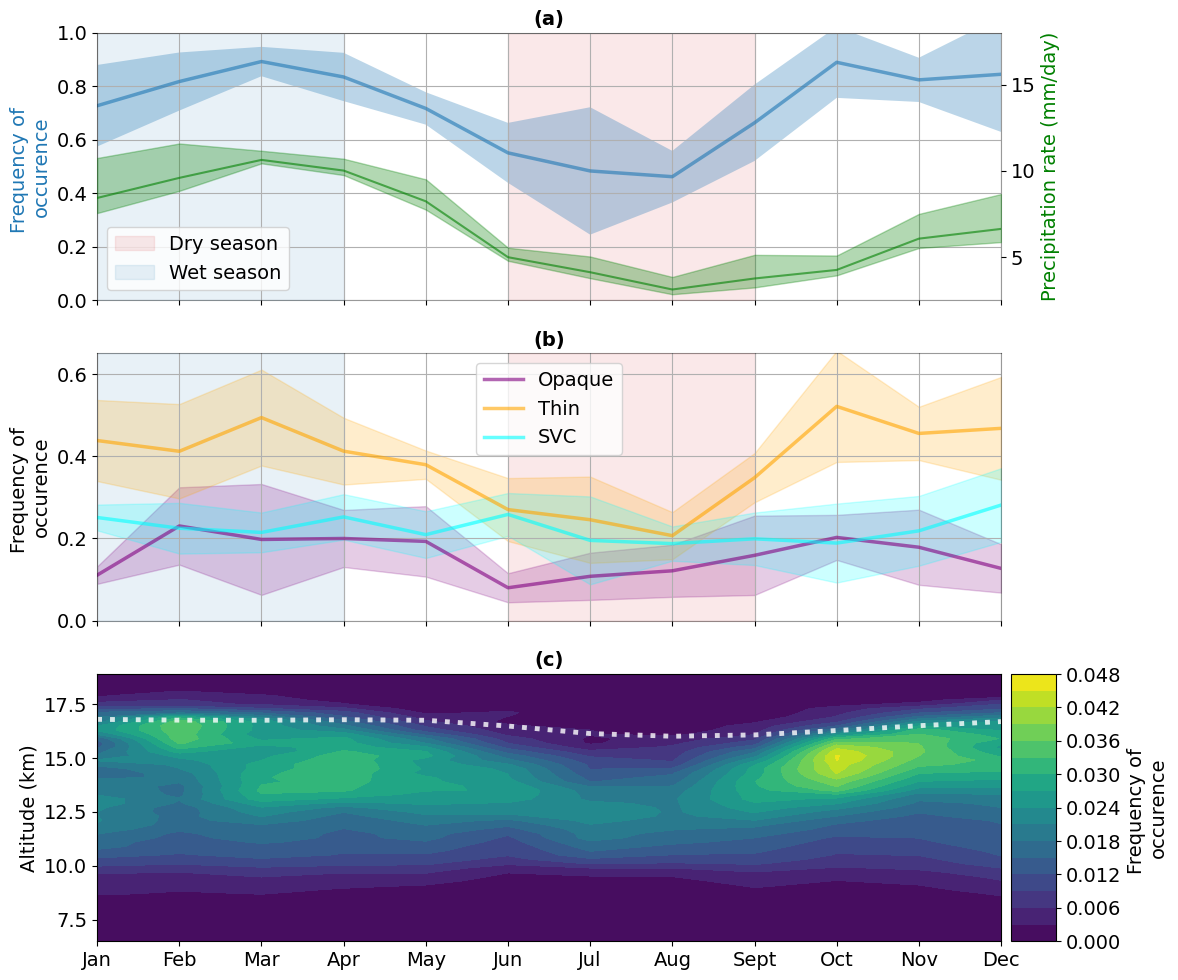

In [9]:
fig, ax = plt.subplots(figsize=(12,10), sharex=True, nrows=3)
cax = []
for axi in ax:
    divider1 = make_axes_locatable(axi)
    cax.append(divider1.append_axes("right", size="5%", pad=0.1))
ciclo_anual(ax[0], '(a)', cax[0])
ciclo_anual_cat(ax[1], '(b)', cax[1])
prob(ax[2], '(c)', cax[2])

fig.tight_layout()
plt.savefig(f"{DIR_SAVE}/sazonal_freq_ocorrencia", dpi=300)
plt.show()

# Propriedades Ópticas e Geométricas
## Histogramas

In [10]:
def create_histogram(column, divide=False, nbins=50, ax_=None, order=None):
    """
    Creates a histogram of the given column in the dataframe, separated by the period.

    Args:
    df: pandas DataFrame
    column: string, name of the column to create the histogram for (z_bases or z_tops)

    Returns:
    None
    """

    nbins = np.arange(8, 20.5, .5) if column in ["z_bases", "z_tops"] else nbins
    nbins = np.arange(0, 8.5, .5) if column in ["thickness"] else nbins
    nbins = np.arange(-9, 4.5, .5) if column in ["tropopause_top", "tropopause_base"] else nbins

    # Separate the data by period
    df_ = df[df.cirrus]
    total_data = df_[column].copy()
    dry_data = df_[df_.period.isin(['Dry'])][column].copy()
    wet_data = df_[df_.period.isin(['Wet'])][column].copy()

    if divide:
        total_data /= 1e3
        dry_data /= 1e3
        wet_data /= 1e3

    if order is not None:
        ax_.text(.9, 0.5, order, transform=ax_.transAxes, verticalalignment='center',
                 horizontalalignment='center', weight='bold')
    # Create the histograms
    if column != "cod":
        if column == "lidar_ratio":
            total_data = total_data[df_.lidar_ratio != 25]
            dry_data = dry_data[df_.lidar_ratio != 25]
            wet_data = wet_data[df_.lidar_ratio != 25]
        ax_.hist(total_data, alpha=0.7, bins=nbins, weights=np.full(len(total_data), 1/len(total_data)), edgecolor='k',
                histtype='step', linewidth=2.5, label=LABELS_PERIOD[0])
        ax_.hist(dry_data, alpha=0.7, bins=nbins, weights=np.full(len(dry_data), 1/len(dry_data)), edgecolor='#d62728',
                histtype='step', linewidth=2, label=LABELS_PERIOD[3])
        ax_.hist(wet_data, alpha=0.7, bins=nbins, weights=np.full(len(wet_data), 1/len(wet_data)),edgecolor='#1f77b4',
                histtype='step', linewidth=2, label=LABELS_PERIOD[1])
    else:
        xmin = total_data.min() * 10
        xmax = total_data.max() * 10
        bins = np.logspace(np.log10(xmin), np.log10(xmax), nbins)
        ax_.hist(total_data, alpha=0.7, bins=bins, weights=np.full(len(total_data), 1/len(total_data)), edgecolor='k',
                histtype='step', linewidth=2.5, label=LABELS_PERIOD[0])
        ax_.hist(dry_data, alpha=0.7, bins=bins, weights=np.full(len(dry_data), 1/len(dry_data)), edgecolor='#d62728',
                histtype='step', linewidth=2, label=LABELS_PERIOD[3])
        ax_.hist(wet_data, alpha=0.5, bins=bins, weights=np.full(len(wet_data), 1/len(wet_data)),edgecolor='#1f77b4',
                histtype='step', linewidth=2, label=LABELS_PERIOD[1])
        ax_.set_xscale("log")

    # Set the labels and title
    ax_.set_xlabel(LABELS[column], fontsize=17)
    if (column == "z_bases") | (column == "z_tops") | (column=="tropopause_base") | (column=="thickness") | (column=="cod"):
        ax_.set_ylabel('Relative frequency', fontsize=17)

    # Add the legend
    if (column=="z_bases"):
        ax_.legend(loc='upper right')
    ax_.grid()

    # Show the plot
    for side in ['right', 'top', 'bottom', 'left']:
        ax_.spines[side].set_alpha(0.4)

def create_histogram_cate(column, period="Total", divide=False, nbins=15, ax_=None, order=None):
    """
    Creates a histogram of the given column in the dataframe, separated by the period.

    Args:
    df: pandas DataFrame
    column: string, name of the column to create the histogram for (z_bases or z_tops)

    Returns:
    None
    """
    nbins = np.arange(8, 20.5, .5) if column in ["z_bases", "z_tops"] else nbins
    nbins = np.arange(0, 10.5, .5) if column in ["thickness"] else nbins
    nbins = np.arange(-9, 4.5, .5) if column in ["tropopause_top", "tropopause_base"] else nbins

    df_ = (df[(df.cirrus) ]
           if period=="Total"
           else df[((df.cirrus)) & (df.period == period)])

    df_ = df_[df_.lidar_ratio != 25] if column=="lidar_ratio" else df_.copy()

    # Separate the data by period
    total_data = df_[column]
    thin_data = df_[df_['class_'] == 'thin'][column]
    subvisual_data = df_[df_['class_'] == 'subvisual'][column]
    opaque_data = df_[df_['class_'] == 'opaque'][column]

    if divide:
        total_data /= 1e3
        thin_data /= 1e3
        subvisual_data /= 1e3
        opaque_data /= 1e3

    # Create the histograms
    if order is not None:
        ax_.text(.9, 0.5, order, transform=ax_.transAxes, verticalalignment='center',
                 horizontalalignment='center', weight='bold')
    if column != "cod":
        ax_.hist(subvisual_data, alpha=0.5, bins=nbins, weights=np.full(len(subvisual_data), 1/len(subvisual_data)), edgecolor='#00FFFF',
            histtype='step', linewidth=2.5, label=LABELS_CAT[2])
        ax_.hist(thin_data, alpha=0.7, bins=nbins, weights=np.full(len(thin_data), 1/len(thin_data)), edgecolor='#FFA500',
                histtype='step', linewidth=2.5, label=LABELS_CAT[1])
        ax_.hist(opaque_data, alpha=0.7, bins=nbins, weights=np.full(len(opaque_data), 1/len(opaque_data)),edgecolor='#800080',
                histtype='step', linewidth=2.5, label=LABELS_CAT[0])
    else:
        xmin = 0.005
        xmax = total_data.max()
        bins = np.logspace(np.log10(xmin), np.log10(xmax), nbins)
        ax_.hist(subvisual_data, alpha=0.5, bins=bins, weights=np.full(len(subvisual_data), 1/len(subvisual_data)), edgecolor='#00FFFF',
            histtype='step', linewidth=2.5, label=LABELS_CAT[2])
        ax_.hist(thin_data, alpha=0.7, bins=bins, weights=np.full(len(thin_data), 1/len(thin_data)), edgecolor='#FFA500',
                histtype='step', linewidth=2.5, label=LABELS_CAT[1])
        ax_.hist(opaque_data, alpha=0.7, bins=bins, weights=np.full(len(opaque_data), 1/len(opaque_data)),edgecolor='#800080',
                histtype='step', linewidth=2.5, label=LABELS_CAT[0])
        ax_.set_xscale("log")

    # Set the labels and title
    try:
        ax_.set_xlabel(LABELS[column], fontsize=17)
    except:
        ax_.set_xlabel(column)
    if (column == "z_bases") | (column == "thickness") | (column == 'tropopause_base'):
        ax_.set_ylabel('Relative frequency', fontsize=17)

    # Add the legend
    if (column=="z_bases"):
        ax_.legend(loc='upper right')
    ax_.grid()

    # Show the plot
    for side in ['right', 'top', 'bottom', 'left']:
        ax_.spines[side].set_alpha(0.4)

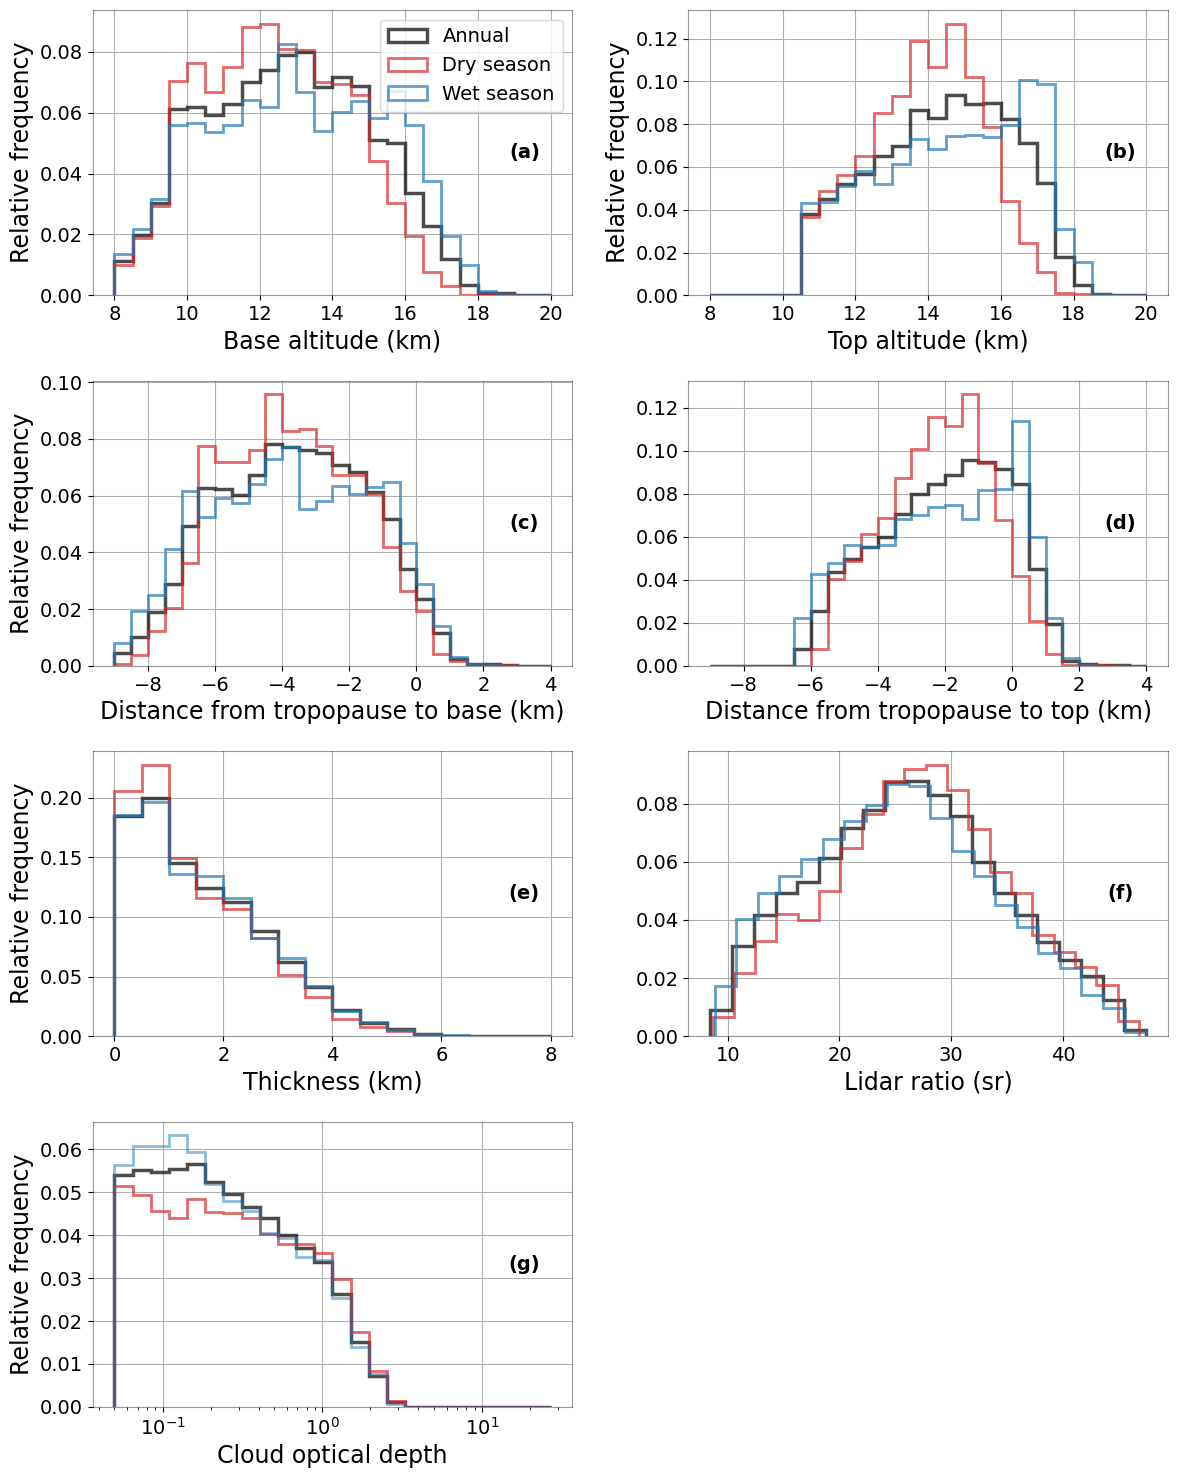

In [11]:
fig, ax = plt.subplots(figsize=(12,15), sharex=False, nrows=4, ncols=2)
ax[3, 1].axis('off')
create_histogram('z_bases', divide=True, nbins=25, ax_=ax[0,0], order='(a)')
create_histogram('z_tops', divide=True, nbins=25, ax_=ax[0,1], order='(b)')
create_histogram('tropopause_base', divide=True, nbins=25, ax_=ax[1,0], order='(c)')
create_histogram('tropopause_top', divide=True, nbins=25, ax_=ax[1,1], order='(d)')
create_histogram('thickness', divide=True, nbins=25, ax_=ax[2,0], order='(e)')
create_histogram('lidar_ratio', divide=False, nbins=20, ax_=ax[2,1], order='(f)')
create_histogram('cod', divide=False, nbins=25, ax_=ax[3,0], order='(g)')

fig.tight_layout()
plt.savefig(f"{DIR_SAVE}/hist_vars", dpi=300)
plt.show()

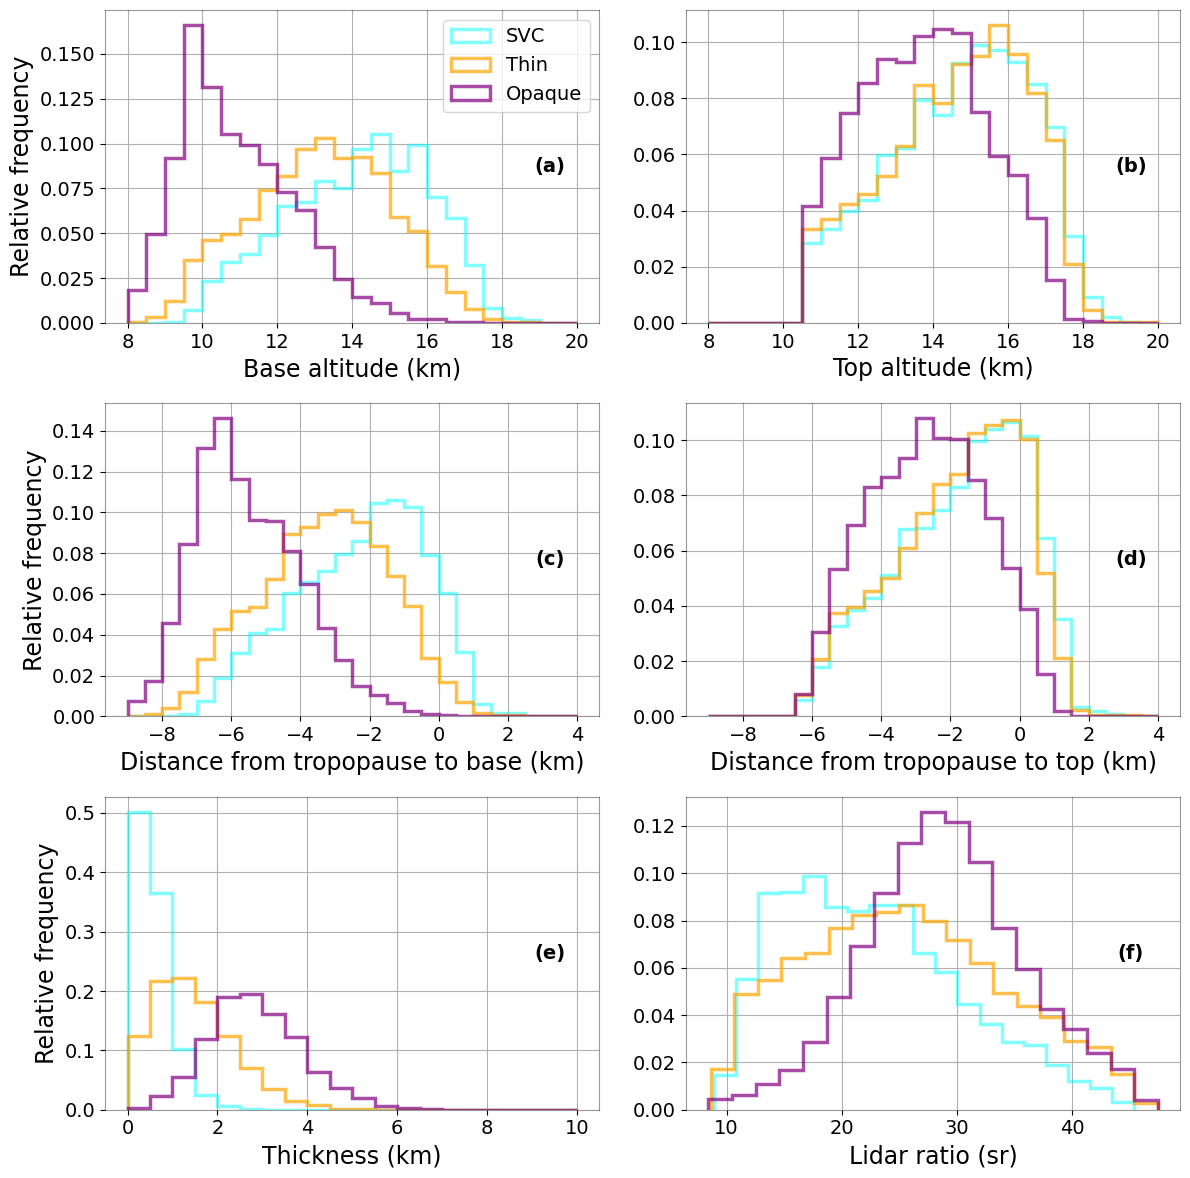

In [12]:
fig, ax = plt.subplots(figsize=(12,12), sharex=False, nrows=3, ncols=2)

create_histogram_cate('z_bases', period="Total", divide=True, nbins=19, ax_=ax[0,0], order='(a)')
create_histogram_cate('z_tops', period="Total", divide=True, nbins=19, ax_=ax[0,1], order='(b)')
create_histogram_cate('tropopause_base', period="Total", divide=True, nbins=19, ax_=ax[1,0], order='(c)')
create_histogram_cate('tropopause_top', period="Total", divide=True, nbins=19, ax_=ax[1,1], order='(d)')
create_histogram_cate('thickness', period="Total", divide=True, nbins=19, ax_=ax[2,0], order='(e)')
create_histogram_cate('lidar_ratio', period="Total", nbins=19, ax_=ax[2,1], order='(f)')

fig.tight_layout()
plt.savefig(f"{DIR_SAVE}/hist_cat", dpi=300)
plt.show()

## Ciclo diurno

In [13]:
def diurnal_cycle(var, divide=False, var_label=None, dim=(6,4), xlabel=True, legend=True, ax_=None, order=None):
    df_ = df[df.cirrus]

    df_ = (df_[(df_.lidar_ratio != 25)].drop_duplicates('time') if var=="lidar_ratio" else df_.copy())

    df_ = (df_
           .assign(time=lambda x: pd.to_datetime(x.time))
           .assign(hour=lambda x: np.round(x.time.dt.hour + x.time.dt.minute / 60)))

    df_.loc[df_.hour == 24, "hour"] = 0

    # Separate the data by period
    data_total = df_.groupby("hour")[var].mean()
    data_wet = df_[df_['period'] == 'Wet'].groupby("hour")[var].mean()
    data_dry = df_[df_['period'] == 'Dry'].groupby("hour")[var].mean()

    data_total_std = (df_.groupby("hour")[var].std(ddof=1)
                      / np.sqrt(df_.groupby("hour")[var].count()))
    df_temp = df.groupby(["period", "hour"])[var]
    data_wet_std = df_temp.std(ddof=1).loc["Wet"] / np.sqrt(df_temp.count().loc["Wet"])
    data_dry_std = df_temp.std(ddof=1).loc["Dry"] / np.sqrt(df_temp.count().loc["Dry"])

    data_total = pd.concat([data_total,
                            pd.Series({12:np.nan, 13:np.nan})]).sort_index()
    data_wet = pd.concat([data_wet,
                              pd.Series({12:np.nan, 13:np.nan})]).sort_index()
    data_dry = pd.concat([data_dry,
                           pd.Series({12:np.nan, 13:np.nan})]).sort_index()


    for data in [data_total, data_dry, data_total_std, data_dry_std]:
        data.loc[11:14] = np.nan

    for data in [data_wet, data_wet_std]:
        data.loc[11:14] = np.nan

    if divide:
        for data in [data_total, data_wet, data_dry, data_total_std, data_wet_std, data_dry_std]:
            data /= 1e3

    if order is not None:
        ax_.text(.5, 0.9, order, transform=ax_.transAxes, verticalalignment='center',
                 horizontalalignment='center', weight='bold')

    colors = ["#1f77b4", "#d62728", "k"]
    labels = ["Wet", "Dry", "Annual"]
    for i, (data, data_std) in enumerate(zip([data_wet, data_dry, data_total],
                                             [data_wet_std, data_dry_std, data_total_std])):

        ax_.plot(data.index, data, color=colors[i], linewidth=2.5, alpha=0.7, label=labels[i])
        ax_.fill_between(data.index, data - data_std, data + data_std,
                        color=colors[i], alpha=0.2)

    ax_.set_ylabel(var_label, fontsize=17)
    if xlabel:
        ax_.set_xlabel("Local time (h)", fontsize=17)

    if legend:
        ax_.legend()
    ax_.grid()
    for side in ['right', 'top', 'bottom', 'left']:
        ax_.spines[side].set_alpha(0.4)

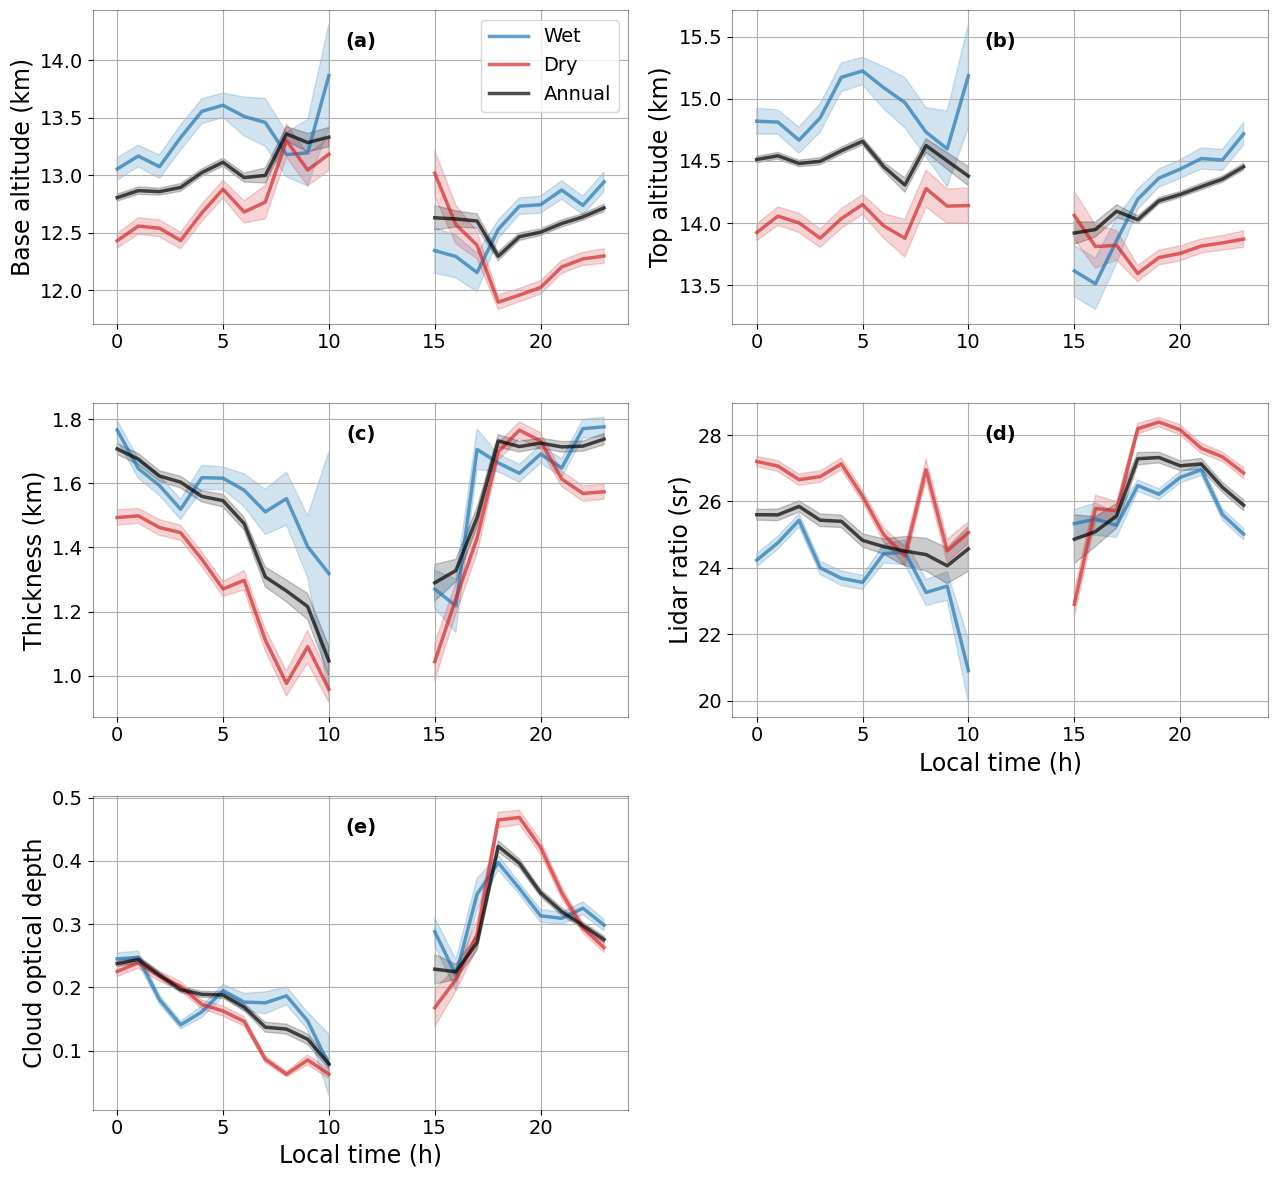

In [14]:
fig, ax = plt.subplots(figsize=(13,12), sharex=False, nrows=3, ncols=2)
ax[2, 1].axis('off')
diurnal_cycle('z_bases', divide=True, var_label=LABELS['z_bases'], xlabel=0, legend=1, ax_=ax[0,0], order='(a)')
diurnal_cycle('z_tops', divide=True, var_label=LABELS['z_tops'], xlabel=0, legend=0, ax_=ax[0,1], order='(b)')
diurnal_cycle('thickness', divide=True, var_label=LABELS['thickness'], xlabel=0, legend=0, ax_=ax[1,0], order='(c)')
diurnal_cycle("lidar_ratio", var_label=LABELS["lidar_ratio"], legend=False, ax_=ax[1,1], order='(d)')
diurnal_cycle("cod", var_label=LABELS["cod"], legend=False, ax_=ax[2,0], order='(e)')

fig.tight_layout()
plt.savefig(f"{DIR_SAVE}/ciclo_vars", dpi=300)
plt.show()

### Classes

In [15]:
def diurnal_cycle_cat(var, divide=False, var_label=None, dim=(6,4), xlabel=True, legend=True, name=None, period=None, ax_=None, order=None):
    df_ = df[df.cirrus]

    if period is not None:
        df_ = df_[df_.period == period]

    df_ = (df_[df_.lidar_ratio != 25].drop_duplicates('time') if var=="lidar_ratio" else df_.copy())

    df_ = (df_
           .assign(time=lambda x: pd.to_datetime(x.time))
           .assign(hour=lambda x: np.round(x.time.dt.hour + x.time.dt.minute / 60)))

    df_.loc[df_.hour == 24, "hour"] = 0

    # Separate the data by class
    data_opaque = df_[df_['class_'] == 'opaque'].groupby("hour")[var].mean()
    data_thin = df_[df_['class_'] == 'thin'].groupby("hour")[var].mean()
    data_svc = df_[df_['class_'] == 'subvisual'].groupby("hour")[var].mean()

    data_opaque_std = df_[df_['class_'] == 'opaque'].groupby("hour")[var].std(ddof=1) / np.sqrt(df_[df_['class_'] == 'opaque'].groupby("hour")[var].count())
    data_thin_std = df_[df_['class_'] == 'thin'].groupby("hour")[var].std(ddof=1) / np.sqrt(df_[df_['class_'] == 'thin'].groupby("hour")[var].count())
    data_svc_std = df_[df_['class_'] == 'subvisual'].groupby("hour")[var].std(ddof=1) / np.sqrt(df_[df_['class_'] == 'subvisual'].groupby("hour")[var].count())

    if divide:
        for data in [data_opaque , data_thin , data_svc , data_opaque_std , data_thin_std , data_svc_std]:
            data /= 1e3

    for data in [data_opaque , data_thin , data_svc , data_opaque_std , data_thin_std , data_svc_std]:
          data.loc[11:14] = np.nan

    data_svc = pd.concat([data_svc, pd.Series([np.nan, np.nan, np.nan, np.nan], index=[11, 12, 13, 14])]).sort_index()
    data_thin = pd.concat([data_thin, pd.Series([np.nan, np.nan, np.nan, np.nan], index=[11, 12, 13, 14])]).sort_index()
    data_opaque = pd.concat([data_opaque, pd.Series([np.nan, np.nan, np.nan, np.nan], index=[11, 12, 13, 14])]).sort_index()

    colors = ['#800080', '#FFA500', '#00FFFF']

    if order is not None:
        ax_.text(.5, 0.9, order, transform=ax_.transAxes, verticalalignment='center',
                 horizontalalignment='center', weight='bold')

    for i, (data, data_std) in enumerate(zip([data_opaque, data_thin, data_svc],
                                             [data_opaque_std, data_thin_std, data_svc_std])):
        ax_.plot(data.index, data, color=colors[i], linewidth=2.5, alpha=0.7, label=LABELS_CAT[i])
        ax_.fill_between(data.index, data - data_std, data + data_std,
                        color=colors[i], alpha=0.2)

    ax_.set_ylabel(var_label, fontsize=17)
    if (var == 'cod'):
        ax_.set_yscale('log')
    if xlabel:
        ax_.set_xlabel("Local time (h)", fontsize=17)
    if legend:
        ax_.legend()
    ax_.grid()
    for side in ['right', 'top', 'bottom', 'left']:
        ax_.spines[side].set_alpha(0.4)

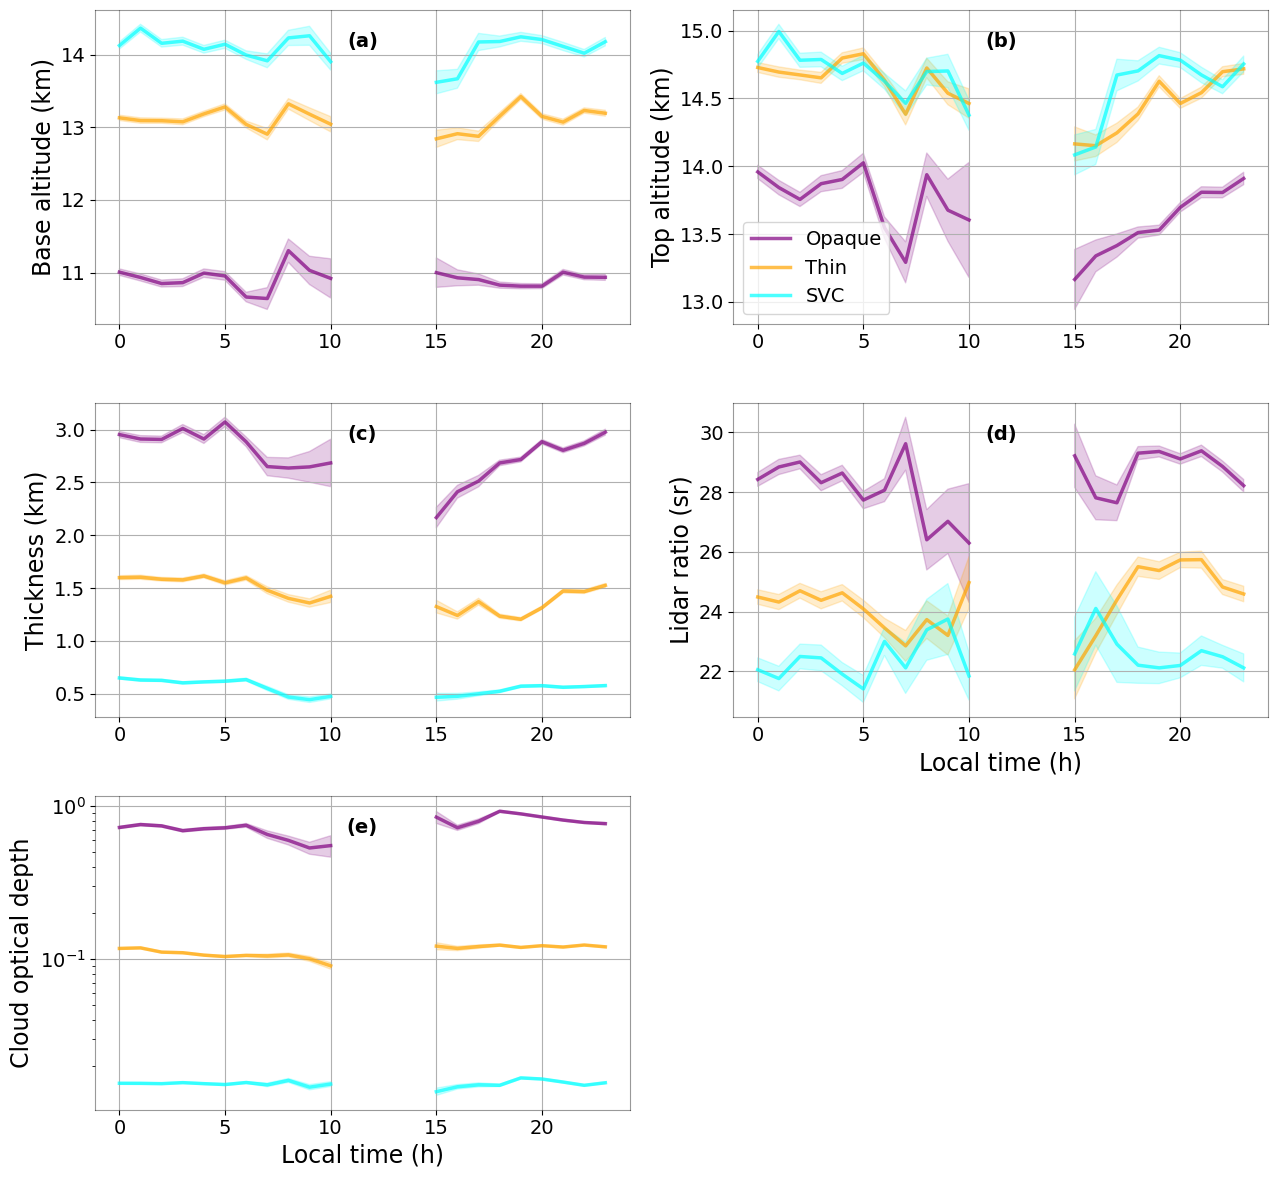

In [16]:
fig, ax = plt.subplots(figsize=(13,12), sharex=False, nrows=3, ncols=2)
ax[2, 1].axis('off')
diurnal_cycle_cat('z_bases', divide=True, var_label=LABELS['z_bases'], xlabel=0, legend=0, ax_=ax[0,0], order='(a)')
diurnal_cycle_cat('z_tops', divide=True, var_label=LABELS['z_tops'], xlabel=0, legend=1, ax_=ax[0,1], order='(b)')
diurnal_cycle_cat('thickness', divide=True, var_label=LABELS['thickness'], xlabel=0, legend=0, ax_=ax[1,0], order='(c)')
diurnal_cycle_cat("lidar_ratio", var_label=LABELS["lidar_ratio"], legend=False, ax_=ax[1,1], order='(d)')
diurnal_cycle_cat("cod", var_label=LABELS["cod"], legend=False, ax_=ax[2,0], order='(e)')

fig.tight_layout()
plt.savefig(f"{DIR_SAVE}/ciclo_cat", dpi=300)
plt.show()

## Ciclo Anual

In [17]:
def compute_percentile(df_, var_x, var_y, percentils=[25, 75]):
    perc = []
    varx_perc = []
    for percentil in percentils:
        perc2 = []
        for varx in df_[var_x].unique():
            var_temp = df_[(df_[var_x] == varx)][var_y]

            var_temp = var_temp[~var_temp.isnull()]

            varx_perc.append(varx)
            perc2.append(np.percentile(var_temp, percentil))
        perc.append(perc2)

    data = {"var_x": varx_perc[:len(perc2)]}
    for percentil, vals in zip(percentils, perc):
        data[f"percentil_{percentil}"] = vals
    return pd.DataFrame(data).sort_values(by="var_x", ignore_index=True).set_index("var_x")


def plot_hist2d(var_x, var_y, divide=False, ybins=30, percentils=[25, 75], colors=None,
                log=False, class_=None, vmax=None, colorbar=True, ax_=None, cax_=None,
                order=None):
    df_ = df[df.cirrus]

    if class_ is not None:
        df_ = df_[df_.class_ == class_]

    df_ = df_[(df_.lidar_ratio != 25) & (~df_.lidar_ratio.isnull())].drop_duplicates('time') if var_y == "lidar_ratio" else df_.copy()

    if divide:
        df_[var_y] /= 1e3

    df_perc = compute_percentile(df_, var_x, var_y, percentils=percentils)
    if log:
        ymin = df_[var_y].min()
        ymax = df_[var_y].max()
        hist, xedges, yedges = np.histogram2d(df_[var_x].to_numpy(),
                                              df_[var_y].to_numpy(),
                                              bins=(len(df_[var_x].unique()), np.logspace(np.log10(ymin), np.log10(ymax), num=ybins)))
        var = df_.groupby(var_x)[var_y].median()
    else:
        ybins = np.linspace(8, 20.5, ybins) if var_y in ['z_bases', 'z_tops'] else ybins
        hist, xedges, yedges = np.histogram2d(df_[var_x].to_numpy(),
                                              df_[var_y].to_numpy(),
                                              bins=(len(df_[var_x].unique()), ybins))
        var = df_.groupby(var_x)[var_y].median()
    hist = hist.T / hist.sum(axis=1)

    h = ax_.contourf(np.arange(hist.shape[1]), yedges[:-1], hist, cmap='viridis', vmin=0, vmax=vmax, levels=15)
    ax_.plot(var.index - 1, var, "k-", alpha=.58, linewidth=3, label='Median')
    for col, line in zip(df_perc.columns, ["k-.", "k--"]):
        ax_.plot(df_perc.index - 1, df_perc[col], line, alpha=.58, linewidth=3, label=LABELS[col])

    if var_y == 'z_tops':
        ax_.plot(np.arange(12), TROPOPAUSE_LIST, ':w', alpha=.8, linewidth=4, label='Tropopause')
    else:
        ax_.plot([],[], ':w', alpha=.8, linewidth=3.5, label='Tropopause')

    ax_.set_xticks(np.arange(12), MONTHS)
    ax_.set_ylabel(LABELS[var_y], fontsize=17)

    if var_y=="z_tops":
        ax_.legend(
            fontsize=15,
            loc='center left',
            bbox_to_anchor=(1.0, 0.5)
        )


    if colorbar:
        cbar = fig.colorbar(h, cax=cax_, ticks=np.linspace(0, vmax, num=5))
        cbar.set_label('Relative frequency', fontsize=17)
    else:
        cax_.axis('off')

    if log:
        ax_.set_yscale('log')

    if order is not None:
        ax_.text(.5, 1.05, order, transform=ax_.transAxes, verticalalignment='center',
                 horizontalalignment='center', weight='bold')

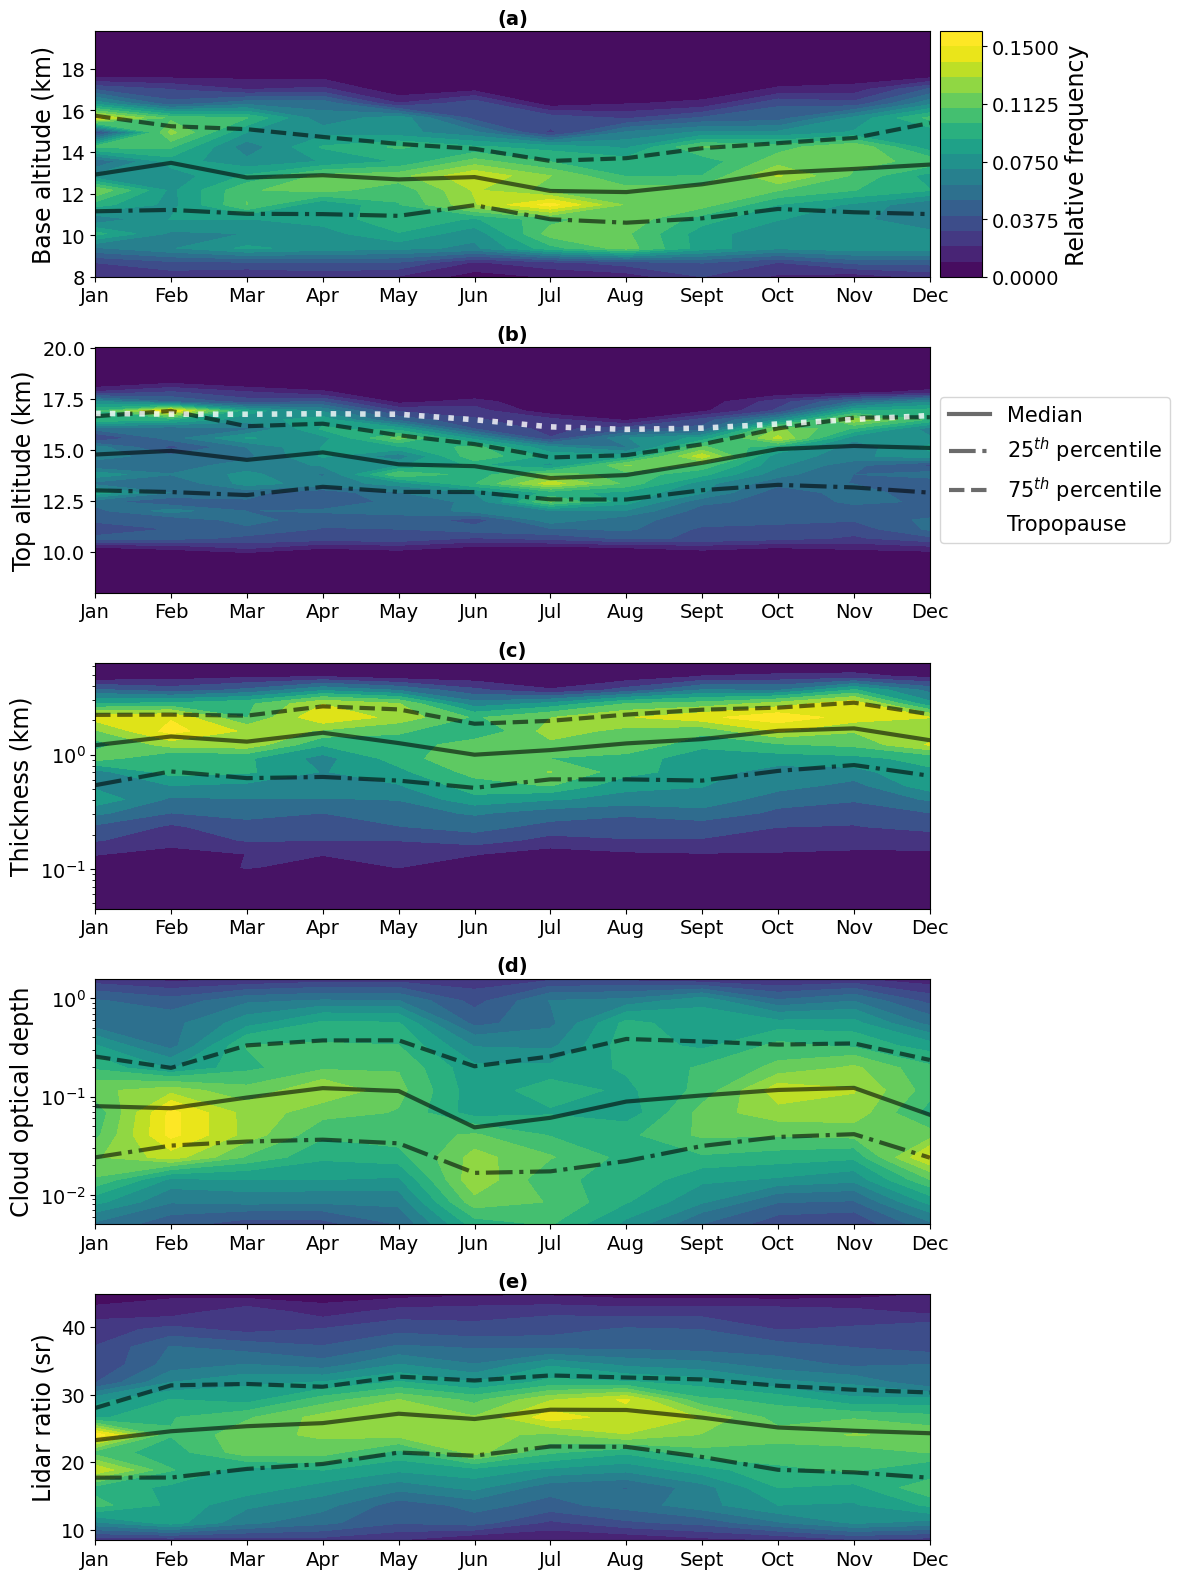

In [18]:
fig, ax = plt.subplots(figsize=(12,16), sharex=False, nrows=5, ncols=1)
cax = []
for axi in ax:
    divider1 = make_axes_locatable(axi)
    cax.append(divider1.append_axes("right", size="5%", pad=0.1))
vmax = .15

plot_hist2d("month", 'z_bases', True, ybins=19, vmax=vmax, colorbar=True, ax_=ax[0], cax_=cax[0], order='(a)')
plot_hist2d("month", 'z_tops', True, ybins=29, vmax=vmax, colorbar=False, ax_=ax[1], cax_=cax[1], order='(b)')
plot_hist2d("month", 'thickness', True, ybins=20, log=True, vmax=vmax, colorbar=False, ax_=ax[2], cax_=cax[2], order='(c)')
plot_hist2d("month", 'cod', False, ybins=13, log=True, vmax=vmax, colorbar=False, ax_=ax[3], cax_=cax[3], order='(d)')
plot_hist2d("month", 'lidar_ratio', False, ybins=15, vmax=vmax, colorbar=False, ax_=ax[4], cax_=cax[4], order='(e)')

fig.tight_layout()
plt.savefig(f"{DIR_SAVE}/anual_vars", dpi=300)
plt.show()

# Tabelas

In [19]:
def create_latex_table(total, wet, trans, dry):
    rows = [
        "No. of layers",
        "Base height (km)",
        "Top height (km)",
        "Thickness (km)",
        "Lidar ratio (sr)",
        "Cloud optical depth",
        "Base above tropopause (%)",
        "Top above tropopause (%)",
        "Relative frequency of opaque cirrus (%)",
        "Relative frequency of thin cirrus (%)",
        "Relative frequency of SVC (%)"
    ]


    for i in range(len(rows)):
        print(rows[i] + f" & {total[i]} & {wet[i]} & {trans[i]} & {dry[i]} \\\\".replace('.', '.'))


def table_fill():
    df_vars = df[df.cirrus & (df.cod >= 0.005)]

    df_lr = df_vars[df_vars.lidar_ratio != 25].drop_duplicates('time')

    total = []
    wet = []
    trans = []
    dry = []

    total.append(df_vars.count()["time"])
    wet.append(df_vars[df_vars.period == "Wet"].count()["time"])
    trans.append(df_vars[df_vars.period == "Trans"].count()["time"])
    dry.append(df_vars[df_vars.period == "Dry"].count()["time"])

    for variable in ["z_bases", "z_tops"]:
        df_vars.loc[:, variable] /= 1e3
        grouped = df_vars.groupby("period")[variable]
        total.append(f"{df_vars[variable].mean():.1f} ({df_vars[variable].std(ddof=1):.1f})")
        wet.append(f"{grouped.mean().loc['Wet']:.1f} ({grouped.std(ddof=1).loc['Wet']:.1f})")
        trans.append(f"{grouped.mean().loc['Trans']:.1f} ({grouped.std(ddof=1).loc['Trans']:.1f})")
        dry.append(f"{grouped.mean().loc['Dry']:.1f} ({grouped.std(ddof=1).loc['Dry']:.1f})")

    variable = "thickness"
    df_vars.loc[:, variable] /= 1e3
    grouped = df_vars.groupby("period")[variable]
    total.append(f"{df_vars[variable].mean():.2f} ({df_vars[variable].std(ddof=1):.2f})")
    wet.append(f"{grouped.mean().loc['Wet']:.2f} ({grouped.std(ddof=1).loc['Wet']:.2f})")
    trans.append(f"{grouped.mean().loc['Trans']:.2f} ({grouped.std(ddof=1).loc['Trans']:.2f})")
    dry.append(f"{grouped.mean().loc['Dry']:.2f} ({grouped.std(ddof=1).loc['Dry']:.2f})")

    grouped = df_lr.groupby("period")["lidar_ratio"]
    total.append(f"{df_lr['lidar_ratio'].mean():.1f} ({df_lr['lidar_ratio'].std(ddof=1):.1f})")
    wet.append(f"{grouped.mean().loc['Wet']:.1f} ({grouped.std(ddof=1).loc['Wet']:.1f})")
    trans.append(f"{grouped.mean().loc['Trans']:.1f} ({grouped.std(ddof=1).loc['Trans']:.1f})")
    dry.append(f"{grouped.mean().loc['Dry']:.1f} ({grouped.std(ddof=1).loc['Dry']:.1f})")

    grouped = df_vars.groupby("period")['cod']
    total.append(f"{df_vars['cod'].mean():.2f} ({df_vars['cod'].std(ddof=1):.2f})")
    wet.append(f"{grouped.mean().loc['Wet']:.2f} ({grouped.std(ddof=1).loc['Wet']:.2f})")
    trans.append(f"{grouped.mean().loc['Trans']:.2f} ({grouped.std(ddof=1).loc['Trans']:.2f})")
    dry.append(f"{grouped.mean().loc['Dry']:.2f} ({grouped.std(ddof=1).loc['Dry']:.2f})")

    for variable in ['tropopause_base_bool', 'tropopause_top_bool']:
        grouped = df_vars.groupby("period")[variable].mean()
        total.append(f"{(df_vars[variable].mean() * 100):.1f}")
        wet.append(f"{(grouped.loc['Wet'] * 100):.1f}")
        trans.append(f"{(grouped.loc['Trans'] * 100):.1f}")
        dry.append(f"{(grouped.loc['Dry'] * 100):.1f}")

    for cat in ['opaque', 'thin', 'subvisual']:
        df_temp = df_vars.dropna()
        grouped = df_temp[df_temp.class_ == cat].groupby("period")['time'].count()
        grouped_total = df_temp.groupby("period")['time'].count()

        total.append(f"{(df_temp[df_temp.class_ == cat].count()['time'] / df_temp.count()['time'] * 100):.1f}")
        wet.append(f"{(grouped.loc['Wet'] / grouped_total.loc['Wet'] * 100):.1f}")
        trans.append(f"{(grouped.loc['Trans'] / grouped_total.loc['Trans'] * 100):.1f}")
        dry.append(f"{(grouped.loc['Dry'] / grouped_total.loc['Dry'] * 100):.1f}")

    create_latex_table(total, wet, trans, dry)


def create_latex_table_cate(total, wet, trans, dry, class_):
    print("\\hline")
    print(f"\\multicolumn{{5}}{{l}}{{{class_}}} \\\\")
    print("\\hline")

    rows = [
        "No. of layers",
        "Base height (km)",
        "Top height (km)",
        "Thickness (km)",
        "Lidar ratio (sr)",
        "Cloud optical depth"
    ]

    for i in range(len(rows)):
        print(rows[i] + f" & {total[i]} & {wet[i]} & {trans[i]} & {dry[i]} \\\\".replace('.', '.'))


def table_fill_cat():
    ptbr_to_en = {'opaque': 'Opaque layers', 'subvisual': 'SVC layers', 'thin': 'Thin layers'}

    df_vars = df[df.cirrus & (df.cod >= 0.005)]

    df_lr = df_vars[df_vars.lidar_ratio != 25].drop_duplicates('time')

    for class_ in ["opaque", "thin", "subvisual"]:
        total = []
        wet = []
        trans = []
        dry = []

        df_vars_temp = df_vars[df_vars.class_ == class_]
        df_lr_temp = df_lr[df_lr.class_ == class_]

        total.append(df_vars_temp.count()["time"])
        wet.append(df_vars_temp[df_vars_temp.period == "Wet"].count()["time"])
        trans.append(df_vars_temp[df_vars_temp.period == "Trans"].count()["time"])
        dry.append(df_vars_temp[df_vars_temp.period == "Dry"].count()["time"])

        for variable in ["z_bases", "z_tops"]:
            df_vars_temp.loc[:, variable] /= 1e3
            grouped = df_vars_temp.groupby("period")[variable]
            total.append(f"{df_vars_temp[variable].mean():.1f} ({df_vars_temp[variable].std(ddof=1):.1f})")
            wet.append(f"{grouped.mean().loc['Wet']:.1f} ({grouped.std(ddof=1).loc['Wet']:.1f})")
            trans.append(f"{grouped.mean().loc['Trans']:.1f} ({grouped.std(ddof=1).loc['Trans']:.1f})")
            dry.append(f"{grouped.mean().loc['Dry']:.1f} ({grouped.std(ddof=1).loc['Dry']:.1f})")

        variable = "thickness"
        df_vars_temp.loc[:, variable] /= 1e3
        grouped = df_vars_temp.groupby("period")[variable]
        total.append(f"{df_vars_temp[variable].mean():.2f} ({df_vars_temp[variable].std(ddof=1):.2f})")
        wet.append(f"{grouped.mean().loc['Wet']:.2f} ({grouped.std(ddof=1).loc['Wet']:.2f})")
        trans.append(f"{grouped.mean().loc['Trans']:.2f} ({grouped.std(ddof=1).loc['Trans']:.2f})")
        dry.append(f"{grouped.mean().loc['Dry']:.2f} ({grouped.std(ddof=1).loc['Dry']:.2f})")

        grouped = df_lr_temp.groupby("period")["lidar_ratio"]
        total.append(f"{df_lr_temp['lidar_ratio'].mean():.1f} ({df_lr_temp['lidar_ratio'].std(ddof=1):.1f})")
        wet.append(f"{grouped.mean().loc['Wet']:.1f} ({grouped.std(ddof=1).loc['Wet']:.1f})")
        trans.append(f"{grouped.mean().loc['Trans']:.1f} ({grouped.std(ddof=1).loc['Trans']:.1f})")
        dry.append(f"{grouped.mean().loc['Dry']:.1f} ({grouped.std(ddof=1).loc['Dry']:.1f})")

        if class_ != "subvisual":
            grouped = df_vars_temp.groupby("period")['cod']
            total.append(f"{df_vars_temp['cod'].mean():.2f} ({df_vars_temp['cod'].std(ddof=1):.2f})")
            wet.append(f"{grouped.mean().loc['Wet']:.2} ({grouped.std(ddof=1).loc['Wet']:.2f})")
            trans.append(f"{grouped.mean().loc['Trans']:.2f} ({grouped.std(ddof=1).loc['Trans']:.2f})")
            dry.append(f"{grouped.mean().loc['Dry']:.2f} ({grouped.std(ddof=1).loc['Dry']:.2f})")
        else:
            grouped = df_vars_temp.groupby("period")['cod']
            total.append(f"{df_vars_temp['cod'].mean():.3f} ({df_vars_temp['cod'].std(ddof=1):.3f})")
            wet.append(f"{grouped.mean().loc['Wet']:.3} ({grouped.std(ddof=1).loc['Wet']:.3f})")
            trans.append(f"{grouped.mean().loc['Trans']:.3f} ({grouped.std(ddof=1).loc['Trans']:.3f})")
            dry.append(f"{grouped.mean().loc['Dry']:.3f} ({grouped.std(ddof=1).loc['Dry']:.3f})")

        create_latex_table_cate(total, wet, trans, dry, ptbr_to_en[class_])


table_fill()
table_fill_cat()

No. of layers & 64316 & 15459 & 26266 & 22591 \\
Base height (km) & 12.8 (2.2) & 13.1 (2.3) & 13.0 (2.2) & 12.4 (1.9) \\
Top height (km) & 14.4 (1.9) & 14.7 (2.0) & 14.7 (1.9) & 13.9 (1.5) \\
Thickness (km) & 1.62 (1.17) & 1.62 (1.16) & 1.73 (1.22) & 1.48 (1.10) \\
Lidar ratio (sr) & 26.1 (8.3) & 25.3 (8.3) & 25.5 (8.4) & 27.1 (8.0) \\
Cloud optical depth & 0.27 (0.40) & 0.27 (0.39) & 0.27 (0.39) & 0.27 (0.42) \\
Base above tropopause (%) & 3.9 & 4.7 & 4.7 & 2.5 \\
Top above tropopause (%) & 15.3 & 20.3 & 19.6 & 6.8 \\
Relative frequency of opaque cirrus (%) & 26.4 & 25.5 & 26.9 & 26.4 \\
Relative frequency of thin cirrus (%) & 48.4 & 51.6 & 51.1 & 43.0 \\
Relative frequency of SVC (%) & 25.2 & 22.9 & 22.0 & 30.5 \\
\hline
\multicolumn{5}{l}{Opaque layers} \\
\hline
No. of layers & 16978 & 3938 & 7066 & 5974 \\
Base height (km) & 10.9 (1.6) & 11.0 (1.7) & 11.1 (1.7) & 10.6 (1.3) \\
Top height (km) & 13.7 (1.7) & 13.8 (1.8) & 14.0 (1.8) & 13.4 (1.3) \\
Thickness (km) & 2.85 (1.02) & 2.8